# SVM for binary pixel classification

In [160]:
import os
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import random as rd
import time
from joblib import dump, load
from sklearn.metrics import classification_report, plot_confusion_matrix
import pandas as pd

# Reading data
*****

## Image

In [130]:
img_path = "/Users/rpezoa/experiment_data/big_3+/img/3+_19.tif"
im = io.imread(img_path)

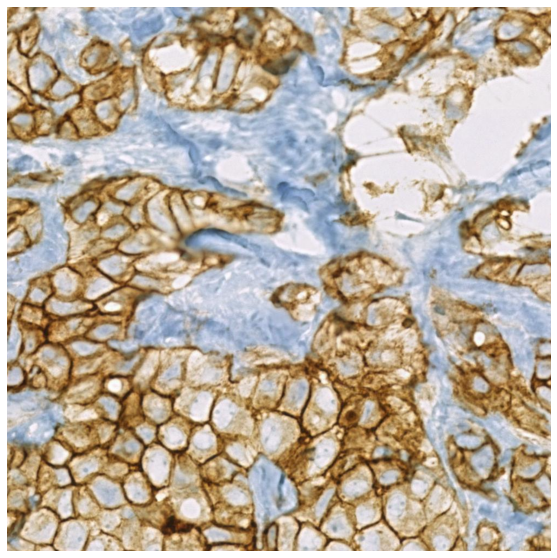

In [131]:
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis("off")
plt.show()


## Mask

In [132]:
mask_path = "/Users/rpezoa/experiment_data/big_3+/masks/3+_19_mask.tif"
im_mask = io.imread(mask_path)

In [133]:
im_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

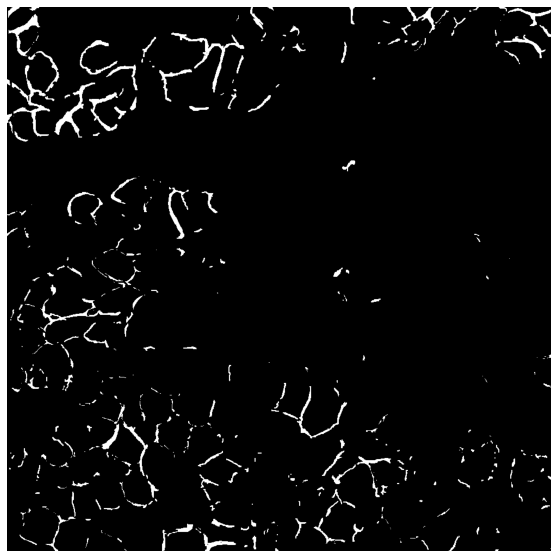

In [134]:
plt.figure(figsize=(10,10))
plt.imshow(255-im_mask, cmap="gray")
plt.axis("off")
plt.show()



## Labels

In [135]:
label_path = "/Users/rpezoa/experiment_data/big_3+/labels/3+_19.npy"
target = np.load(label_path)
print(target, target.shape)

[0 0 0 ... 0 0 0] (1000000,)


## Features

In [136]:
features_file = "/Users/rpezoa/experiment_data/big_3+/features/3+_19_rpr.npy"

In [137]:
im_feat = np.load(features_file)

In [138]:
im_feat.shape

(1000000, 40)

### Showing images features

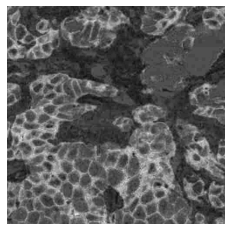

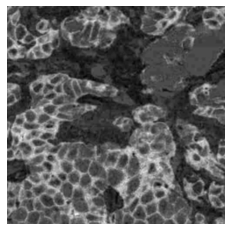

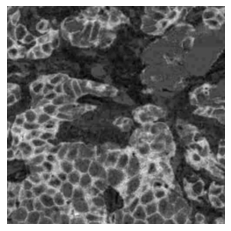

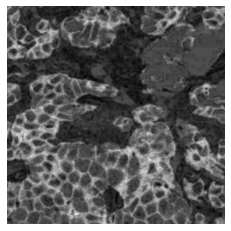

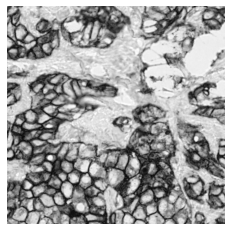

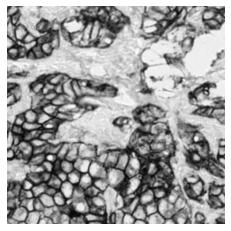

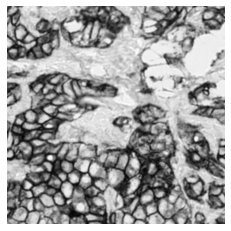

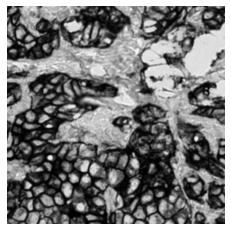

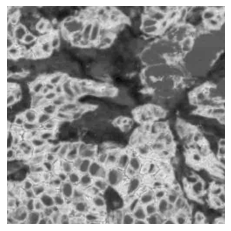

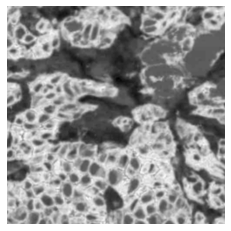

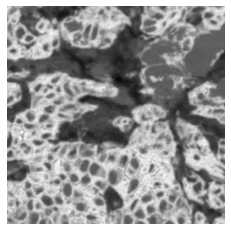

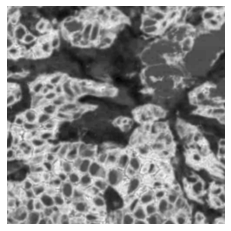

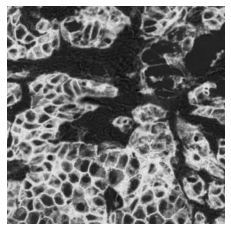

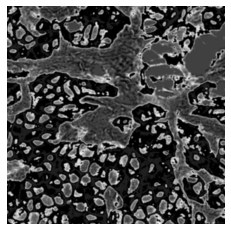

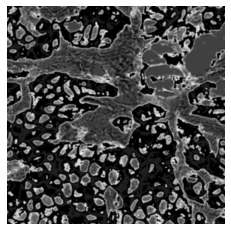

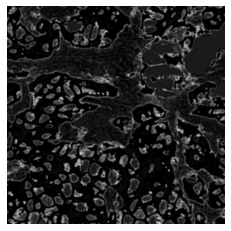

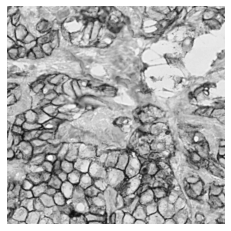

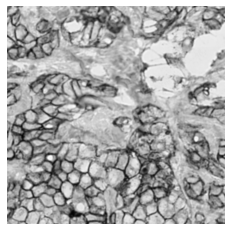

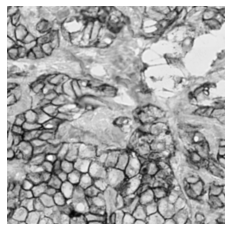

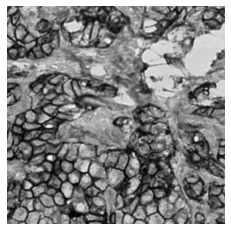

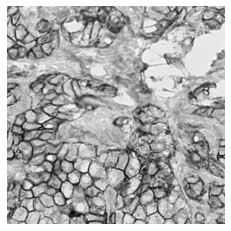

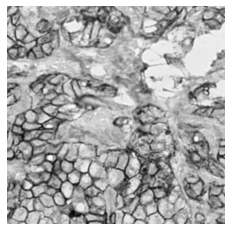

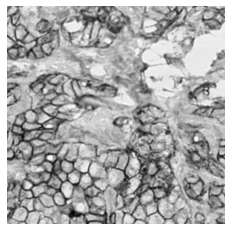

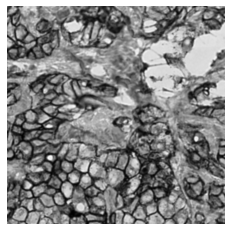

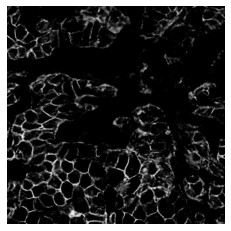

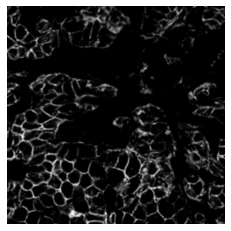

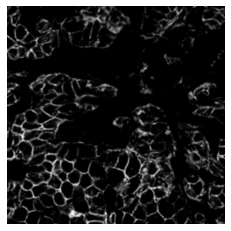

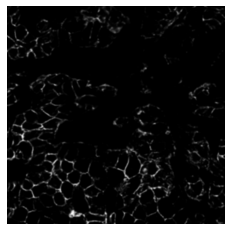

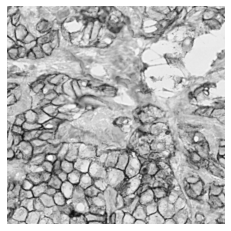

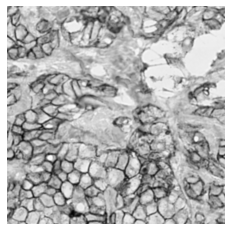

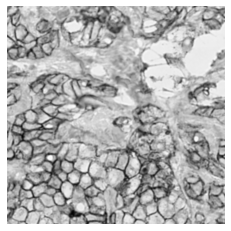

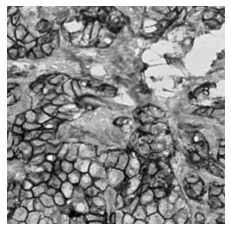

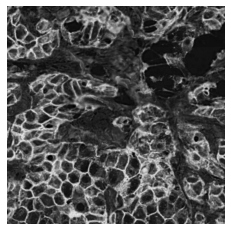

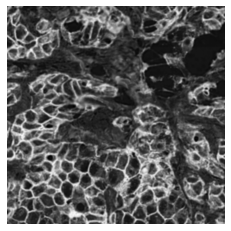

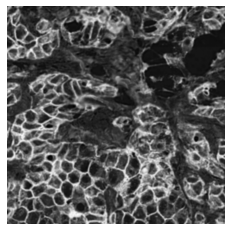

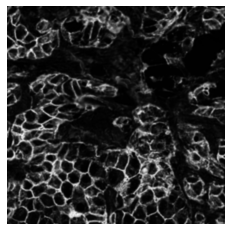

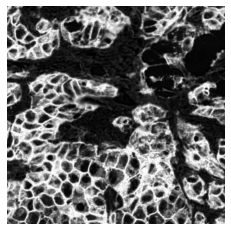

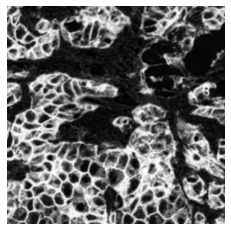

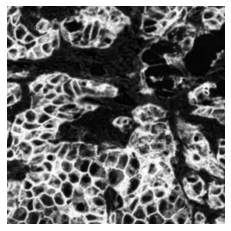

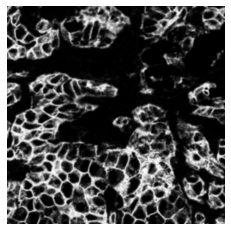

In [47]:
for i in range(im_feat.shape[1]):
    plt.figure()
    plt.imshow(np.reshape(im_feat[:,i], (1000,1000)), cmap="gray")
    plt.axis("off")
    plt.show()

In [79]:
def training_data(X, y, method="strati", size=15000, p_class1=0.3,seed=0):
    if method == "strati":
        mask_0 = y == 0 # Vector de True y False donde el valor de la etiqueta es 0
        mask_1 = y == 1 # Vector de True y False donde el valor de la etiqueta es 1
        idx_0 = np.where(mask_0 == True)[0] # indexes (position) of pixels with target equal 0 (non-mem)
        idx_1 = np.where(mask_1 == True)[0] # indexes (position) of pixels with target equal 1 (mem)
        print("idx_0.shape", idx_0.shape, "idx_1.shape", idx_1.shape)
        n_0 = mask_0.sum() # Cantidad de pixeles de clase non-her2
        n_1 = mask_1.sum() # Cantidad de pixeles de clase her2
        print("non-mem:", n_0, "mem:", n_1)

        y_0 = y[mask_0] 
        y_1 = y[mask_1]

        X_0 = X[mask_0] #only non-mem 
        X_1 = X[mask_1] #only mem
        print("X_0.shape, X_1.shape", X_0.shape, X_1.shape)

        rd.seed(seed)
        rd_idx_0 = rd.sample(range(n_0),int((1-p_class1) * size))
        rd_idx_1 = rd.sample(range(n_1),int(p_class1 * size))

        X_0 = X_0[rd_idx_0,:]
        X_1 = X_1[rd_idx_1,:]

        y_0 = y_0[rd_idx_0]
        y_1 = y_1[rd_idx_1]

        new_idx_0 = idx_0[rd_idx_0]
        new_idx_1 = idx_1[rd_idx_1]

        rd_X = np.concatenate((X_0,X_1),axis=0)
        rd_y = np.concatenate((y_0,y_1),axis=0)
        print("X.shape:", rd_X.shape, "y.shape", rd_y.shape)
        return rd_X, rd_y,new_idx_0,new_idx_1

def testing_data (X,y, new_idx_0, new_idx_1):
    new_idx = np.concatenate((new_idx_0,new_idx_1),axis=0)
    big_inx = np.setdiff1d(np.arange(1000000), new_idx)
    big_x = X[big_inx,:]
    big_y = y[big_inx]
    print("big_x", big_x.shape, "big_y", big_y.shape)
    return big_x, big_y


In [54]:
X, y, id_0, id_1 = training_data(im_feat, target)

idx_0.shape (967983,) idx_1.shape (32017,)
non-mem: 967983 mem: 32017
X_0.shape, X_1.shape (967983, 40) (32017, 40)
X.shape: (15000, 40) y.shape (15000,)


In [81]:
big_X, big_y = testing_data (im_feat, target, id_0, id_1)

big_x (985000, 40) big_y (985000,)


In [103]:
big_X.shape

(985000, 40)

# SVC, kernel RBF

In [57]:
# SVM parameters
svm_type = "C"
kernel = 'rbf'
k = 5
C_r = [-1, 1]
C_step = 0.5
g_r = [-1, 1]
g_step = 0.5
C_range = 10. ** np.arange(C_r[0], C_r[1],C_step)
gamma_range = 10. ** np.arange(g_r[0], g_r[1],g_step)
# score can be: roc_auc, accuracy, recall, precision, f1, average_precision
score = 'f1'
test_size = 0.2
rs = 0
class_weight = "balanced"
bal = False
t_t = False
random_training = False

In [67]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

values, counts = np.unique(y_resampled, return_counts=True)
print(values, counts)
print(rus.sample_indices_)

[0 1] [4500 4500]
[ 6009  2782  8238 ... 14997 14998 14999]


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [{'kernel': [kernel], 'gamma': gamma_range,'C': C_range}]

clf = GridSearchCV(SVC(class_weight = "balanced"), 
                   tuned_parameters, 
                   cv=k, 
                   scoring=score,
                   n_jobs = -1, verbose=1)

if os.path.exists('svm_model.joblib'):
    print("modelo existe ... cargando modelo")
    #clf = load('svm_model.joblib') 
else:
    t1=time.time()
    clf.fit(X_resampled, y_resampled)
    t2=time.time()
    dump(clf, 'svm_model.joblib') 

print("SVM fitting time:", t2-t1)

#------------------------------------------------------  
# Generating predictions and saving the predictions
#best_estimator = clf.best_estimator_


modelo existe ... cargando modelo
SVM fitting time: 1187.8754057884216


## Prediction

In [73]:
pred_vector = best_estimator.predict(X_resampled)


In [83]:
pred_big_X = best_estimator.predict(big_X)

In [101]:
print(pred_vector.shape, pred_big_X.shape, rus.sample_indices_.shape[0])

(9000,) (985000,) 9000


### Training data

In [155]:

d = classification_report(y_resampled, pred_vector,output_dict=True)
display(pd.DataFrame(d))

0            1  accuracy    macro avg  weighted avg
precision     0.949706     0.872258  0.907333     0.910982      0.910982
recall        0.860222     0.954444  0.907333     0.907333      0.907333
f1-score      0.902752     0.911503  0.907333     0.907127      0.907127
support    4500.000000  4500.000000  0.907333  9000.000000   9000.000000

### Testing data

In [164]:
d2 = classification_report(pred_big_X, big_y,output_dict=True)
display(pd.DataFrame(d2))

0              1  accuracy      macro avg  \
precision       0.853074       0.945706  0.855662       0.899390   
recall          0.998174       0.156105  0.855662       0.577140   
f1-score        0.919938       0.267976  0.855662       0.593957   
support    818298.000000  166702.000000  0.855662  985000.000000   

            weighted avg  
precision       0.868751  
recall          0.855662  
f1-score        0.809599  
support    985000.000000

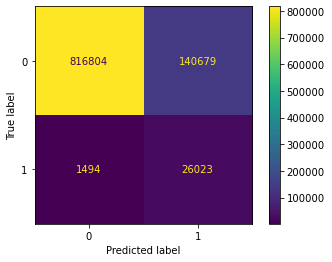

In [162]:
plot_confusion_matrix(best_estimator, big_X, big_y)

# Visualizing prediction
*****

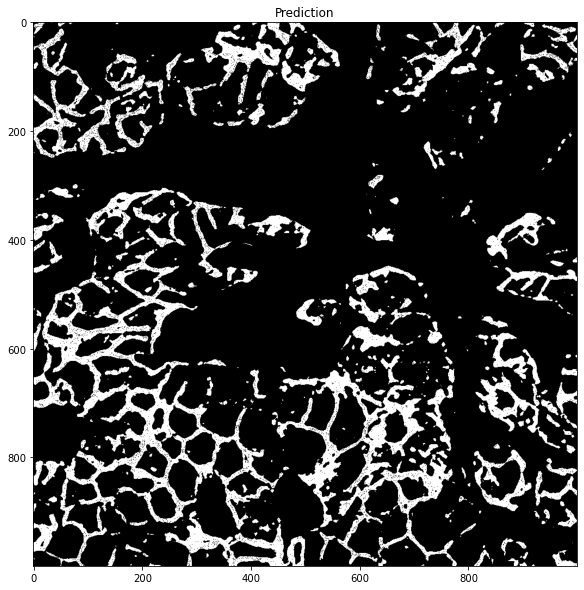

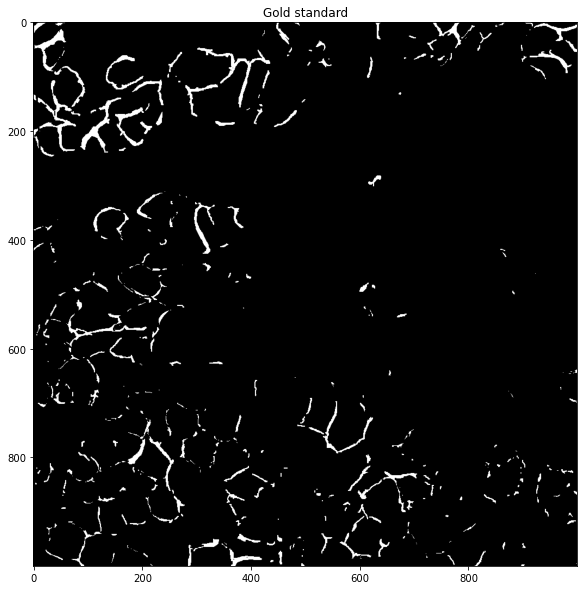

In [148]:
new_idx = np.concatenate((id_0,id_1),axis=0)
big_inx = np.setdiff1d(np.arange(1000000), new_idx)
new_im = np.zeros((1000000))
for i, indice in enumerate(big_inx):
    new_im[indice] = pred_big_X[i]

plt.figure(figsize=(10,10))
plt.imshow(np.reshape(new_im,(1000,1000)), cmap="gray")
plt.title("Prediction")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.reshape(target,(1000,1000)), cmap="gray")
plt.title("Gold standard")
plt.show()

# Linear SVM

In [150]:
# 
from sklearn.svm import LinearSVC


clf2 = LinearSVC(random_state=0, tol=1e-5)
t1=time.time()
clf2.fit(X_resampled, y_resampled)
t2=time.time()
dump(clf, 'svm_linear_model.joblib') 

['svm_linear_model.joblib']

In [152]:
y_pred2 = clf2.predict(X_resampled)

In [153]:
y_pred2_big = clf2.predict(big_X)

In [159]:
d3 = classification_report(y_resampled, y_pred2,output_dict=True)
display(pd.DataFrame(d3))

0            1  accuracy    macro avg  weighted avg
precision     0.927508     0.868432  0.895778     0.897970      0.897970
recall        0.858667     0.932889  0.895778     0.895778      0.895778
f1-score      0.891761     0.899507  0.895778     0.895634      0.895634
support    4500.000000  4500.000000  0.895778  9000.000000   9000.000000

In [157]:
d4 = classification_report(big_y, y_pred2_big,output_dict=True)
display(pd.DataFrame(d4))

0             1  accuracy      macro avg   weighted avg
precision       0.997530      0.157319  0.859352       0.577425       0.974058
recall          0.857434      0.926118  0.859352       0.891776       0.859352
f1-score        0.922191      0.268952  0.859352       0.595572       0.903942
support    957483.000000  27517.000000  0.859352  985000.000000  985000.000000

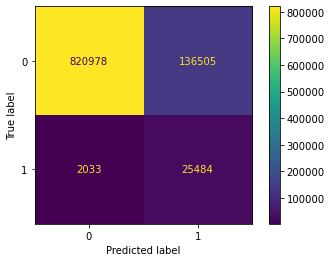

In [163]:
plot_confusion_matrix(clf2, big_X, big_y)

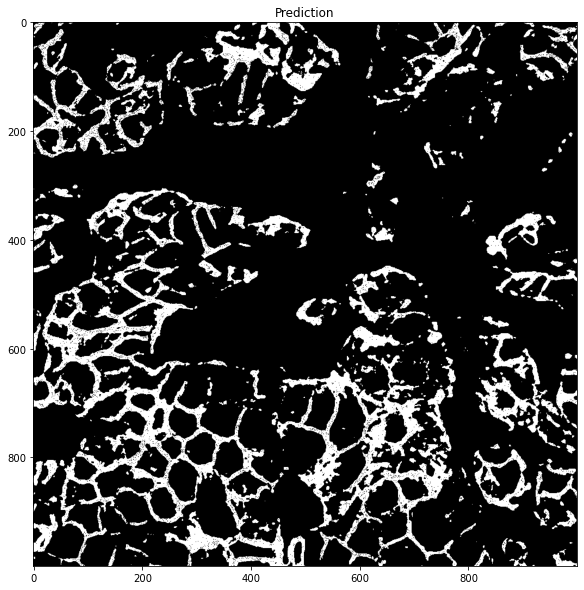

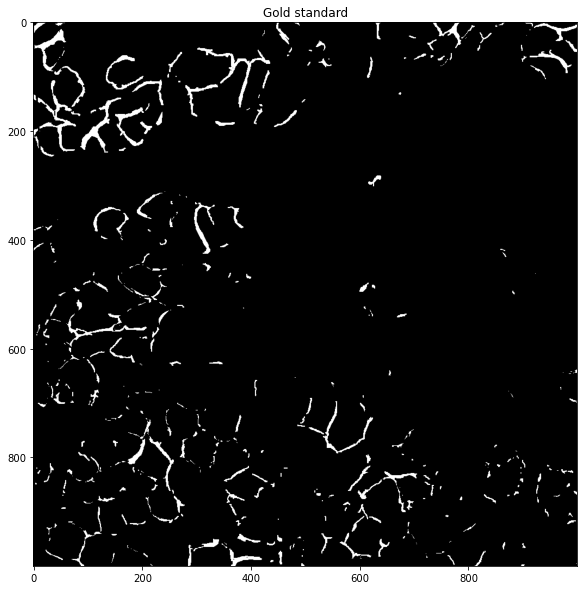

In [158]:
new_idx = np.concatenate((id_0,id_1),axis=0)
big_inx = np.setdiff1d(np.arange(1000000), new_idx)
new_im = np.zeros((1000000))
for i, indice in enumerate(big_inx):
    new_im[indice] = y_pred2_big[i]

plt.figure(figsize=(10,10))
plt.imshow(np.reshape(new_im,(1000,1000)), cmap="gray")
plt.title("Prediction")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.reshape(target,(1000,1000)), cmap="gray")
plt.title("Gold standard")
plt.show()